In [1]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn
import imblearn
%matplotlib inline
#from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')

# Chargement des donnees


In [3]:
# Définir les chemins des fichiers et les identifiants correspondants des stations
stations_donnees = {
    'CIV-00001.csv': 'Station1',
    'CIV-00033.csv': 'Station2',
    'CIV-00004.csv': 'Station3',
}

tableaux_donnees = []  # Liste pour stocker les dataframes

for chemin_fichier, id_station in stations_donnees.items():
    # Charger le fichier CSV
    tableau = pd.read_csv(chemin_fichier, index_col=0)
    # Réinitialiser l'index pour transformer l'index temporel en colonne
    tableau.reset_index(inplace=True)
    # Renommer la colonne d'index en 'temps'
    tableau.rename(columns={'index': 'temps'}, inplace=True)
    # Convertir la colonne 'temps' au format datetime
    tableau['temps'] = pd.to_datetime(tableau['temps'])
    # Filtrer uniquement les colonnes nécessaires, y compris la colonne 'temps'
    tableau = tableau[['temps', 'signal_std', 'signal_rad', 'pluie']]
    # Ajouter une colonne 'id_station' avec l'identifiant de la station
    tableau['id_station'] = id_station
    # Ajouter le dataframe à la liste
    tableaux_donnees.append(tableau)

# Concaténer tous les tableaux en un seul
tableau_final = pd.concat(tableaux_donnees, ignore_index=True)


In [4]:
tableau_final

,temps,signal_std,signal_rad,pluie,id_station
0,2023-02-01 00:00:00,-17.08,-25.95,0.0,Station1
1,2023-02-01 00:01:00,-17.11,-25.96,0.0,Station1
2,2023-02-01 00:02:00,-17.04,-25.93,0.0,Station1
3,2023-02-01 00:03:00,-17.06,-25.94,0.0,Station1
4,2023-02-01 00:04:00,-17.05,-25.93,0.0,Station1
...,...,...,...,...,...
120955,2023-02-28 23:55:00,-22.06,-28.71,0.0,Station3
120956,2023-02-28 23:56:00,-22.05,-28.70,0.0,Station3
120957,2023-02-28 23:57:00,-22.06,-28.72,0.0,Station3
120958,2023-02-28 23:58:00,-22.04,-28.71,0.0,Station3


# Preprocessing Des Donnees


# Extraction des Caractéristiques Temporelles
Nous allons extraire les caractéristiques horaires à partir de la colonne 'temps' afin de capturer la nature cyclique du temps. Nous utiliserons la transformation sinusoïdale et cosinus pour représenter cette cyclicité. En effet, l'heure de la journée est une caractéristique cyclique, où la distance entre 23 et 0 est la même que celle entre 0 et 1.

In [5]:
# Ajouter l'heure de la journée comme caractéristique
tableau_final['heure'] = tableau_final['temps'].dt.hour

# Utiliser la transformation sinusoïdale et cosinus pour capturer la nature cyclique de l'heure
tableau_final['heure_cos'] = np.cos(2 * np.pi * tableau_final['heure'] / 24)
tableau_final['heure_sin'] = np.sin(2 * np.pi * tableau_final['heure'] / 24)

# Supprimer la colonne 'heure' car elle n'est plus nécessaire
tableau_final.drop(columns=['heure'], inplace=True)

# Train Test Split


Nous devons d'abord diviser les données en ensembles d'entraînement et de test avant d'effectuer tout prétraitement ou ingénierie des fonctionnalités. Cela permet d'éviter toute fuite de données de l'ensemble de test vers l'ensemble d'entraînement. Nous prendrons les 7 derniers jours de données de chaque station comme ensemble de test et le reste comme ensemble d'entraînement.

In [6]:
# Nous commençons par trier le tableau par 'temps' et 'id_station' afin de s'assurer que les données sont ordonnées par temps et par station
tableau_final.sort_values(by=['temps', 'id_station'], inplace=True)
tableau_final


,temps,signal_std,signal_rad,pluie,id_station,heure_cos,heure_sin
0,2023-02-01 00:00:00,-17.08,-25.95,0.0,Station1,1.000000,0.000000
40320,2023-02-01 00:00:00,-20.67,-29.09,0.0,Station2,1.000000,0.000000
80640,2023-02-01 00:00:00,-21.97,-28.71,0.0,Station3,1.000000,0.000000
1,2023-02-01 00:01:00,-17.11,-25.96,0.0,Station1,1.000000,0.000000
40321,2023-02-01 00:01:00,-20.66,-29.09,0.0,Station2,1.000000,0.000000
...,...,...,...,...,...,...,...
80638,2023-02-28 23:58:00,-20.84,-29.09,0.0,Station2,0.965926,-0.258819
120958,2023-02-28 23:58:00,-22.04,-28.71,0.0,Station3,0.965926,-0.258819
40319,2023-02-28 23:59:00,-17.26,-25.92,0.0,Station1,0.965926,-0.258819
80639,2023-02-28 23:59:00,-20.81,-29.09,0.0,Station2,0.965926,-0.258819


In [7]:
# Nous trouvons le timestamp maximal dans le jeu de données et l'utilisons pour calculer le timestamp de coupure pour l'ensemble de test et l'ensemble de test de prévision
timestamp_max = tableau_final['temps'].max()
timestamp_coupure = timestamp_max - pd.Timedelta(days=7)

# Calcul du timestamp de coupure pour l'ensemble de test de prévision
# La coupure de prévision est fixée à 12h le dernier jour du mois
timestamp_coupure_prevision = timestamp_max.replace(hour=12, minute=0, second=0, microsecond=0)

# Nous divisons le jeu de données en ensembles d'entraînement et de test en fonction du timestamp de coupure
X_entrainement_validation = tableau_final[tableau_final['temps'] <= timestamp_coupure].copy()
X_test = tableau_final[tableau_final['temps'] > timestamp_coupure].copy()
X_entrainement_validation_prevision = tableau_final[tableau_final['temps'] < timestamp_coupure_prevision].copy()
X_test_prevision = tableau_final[tableau_final['temps'] >= timestamp_coupure_prevision].copy()


In [8]:
(X_test_prevision[X_test_prevision['id_station'] == 'Station1'])['pluie'].sum()


23.0

In [9]:
X_entrainement_validation_prevision


,temps,signal_std,signal_rad,pluie,id_station,heure_cos,heure_sin
0,2023-02-01 00:00:00,-17.08,-25.95,0.0,Station1,1.000000,0.000000
40320,2023-02-01 00:00:00,-20.67,-29.09,0.0,Station2,1.000000,0.000000
80640,2023-02-01 00:00:00,-21.97,-28.71,0.0,Station3,1.000000,0.000000
1,2023-02-01 00:01:00,-17.11,-25.96,0.0,Station1,1.000000,0.000000
40321,2023-02-01 00:01:00,-20.66,-29.09,0.0,Station2,1.000000,0.000000
...,...,...,...,...,...,...,...
79918,2023-02-28 11:58:00,-21.05,-29.31,0.0,Station2,-0.965926,0.258819
120238,2023-02-28 11:58:00,-22.37,-28.87,0.0,Station3,-0.965926,0.258819
39599,2023-02-28 11:59:00,NaN,NaN,0.0,Station1,-0.965926,0.258819
79919,2023-02-28 11:59:00,-21.05,-29.30,0.0,Station2,-0.965926,0.258819


### Nous vérifions que l'ensemble de test contient suffisamment de points pluvieux pour être utile à l'évaluation.

In [10]:
# Vérification de la proportion et du nombre de points pluvieux dans les ensembles de test et d'entraînement par rapport au nombre total de points pluvieux
print(
    f"Proportion de points pluvieux dans le jeu de données original : Nombre : {tableau_final['pluie'].sum()} Pourcentage : {np.round(tableau_final['pluie'].mean() * 100, 2)}%\n")

print(
    f"Proportion de points pluvieux dans l'ensemble d'entraînement : Nombre : {X_entrainement_validation['pluie'].sum()} Pourcentage : {np.round(X_entrainement_validation['pluie'].mean() * 100, 2)}%\n")

print(
    f"Proportion de points pluvieux dans l'ensemble de test : Nombre : {X_test['pluie'].sum()} Pourcentage : {np.round(X_test['pluie'].mean() * 100, 2)}%")


Proportion de points pluvieux dans le jeu de données original : Nombre : 2252.0 Pourcentage : 1.86%

Proportion de points pluvieux dans l'ensemble d'entraînement : Nombre : 1422.0 Pourcentage : 1.57%

Proportion de points pluvieux dans l'ensemble de test : Nombre : 830.0 Pourcentage : 2.74%


## Gestion des valeurs manquantes

### Nous vérifions d’abord les valeurs manquantes dans l’ensemble de données.

In [11]:
# Vérification des valeurs manquantes dans le jeu de données
print(f'Valeurs manquantes dans l\'ensemble d\'entraînement :\n{X_entrainement_validation.isna().sum()}\n')
print(f'Valeurs manquantes dans l\'ensemble de test :\n{X_test.isna().sum()}')

Valeurs manquantes dans l'ensemble d'entraînement :
temps            0
signal_std    1472
signal_rad    1472
pluie            0
id_station       0
heure_cos        0
heure_sin        0
dtype: int64

Valeurs manquantes dans l'ensemble de test :
temps           0
signal_std    122
signal_rad    122
pluie           0
id_station      0
heure_cos       0
heure_sin       0
dtype: int64


In [12]:
print(f'Le poucentage des valeurs manquantes dans l\'ensemble d\'entraînement :\n{X_entrainement_validation.isnull().mean()*100}\n')
print(f'Le pourcentage des valeurs manquantes dans l\'ensemble de test :\n{X_test.isnull().mean()*100}')

Le poucentage des valeurs manquantes dans l'ensemble d'entraînement :
temps         0.000000
signal_std    1.622575
signal_rad    1.622575
pluie         0.000000
id_station    0.000000
heure_cos     0.000000
heure_sin     0.000000
dtype: float64

Le pourcentage des valeurs manquantes dans l'ensemble de test :
temps         0.000000
signal_std    0.403439
signal_rad    0.403439
pluie         0.000000
id_station    0.000000
heure_cos     0.000000
heure_sin     0.000000
dtype: float64


## La distribution des données (signal_std et signal_rad) pour voir comment elles varient

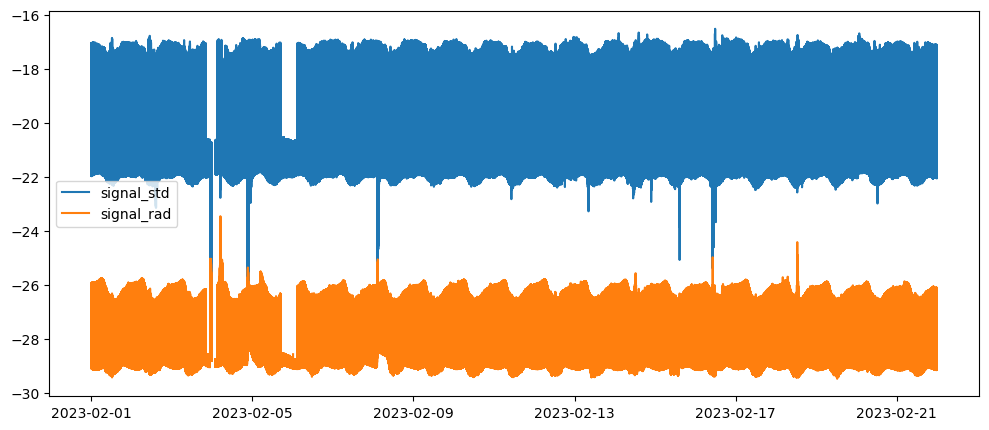

In [13]:

plt.figure(figsize=(12, 5))
plt.plot(X_entrainement_validation['temps'], X_entrainement_validation['signal_std'], label="signal_std")
plt.plot(X_entrainement_validation['temps'], X_entrainement_validation['signal_rad'], label="signal_rad")
plt.legend()
plt.show()


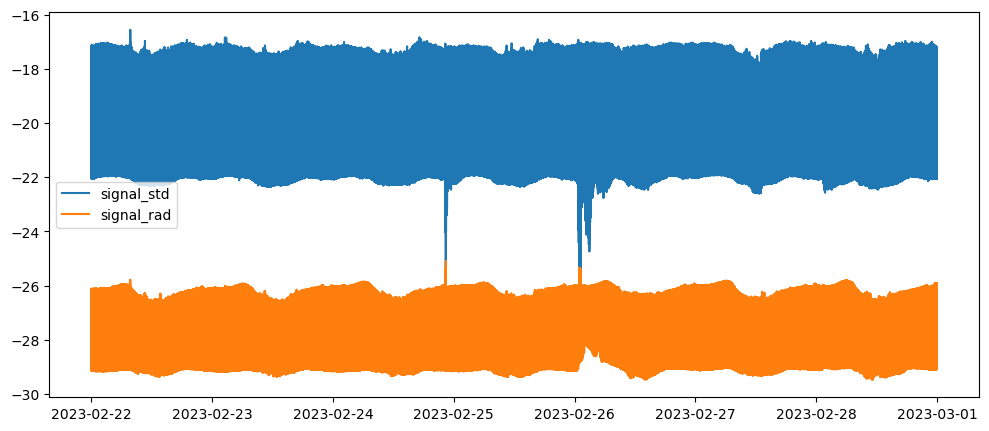

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(X_test['temps'], X_test['signal_std'], label="signal_std")
plt.plot(X_test['temps'], X_test['signal_rad'], label="signal_rad")
plt.legend()
plt.show()

<h3>faire l'histogramme de la distribution des donnees et rajouter une explication boxplot de pourquoi cela signifie quil n y a pas de valeurs extremes lire la doc de boxplot </h3>

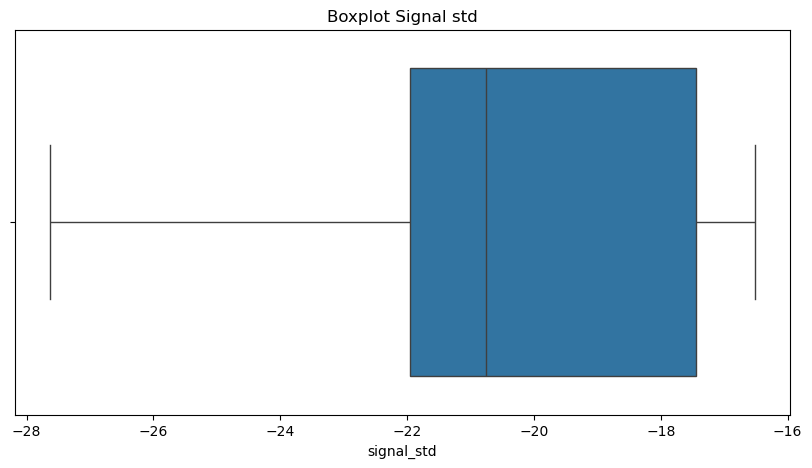

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=X_entrainement_validation['signal_std'])
plt.title("Boxplot Signal std")
plt.show()

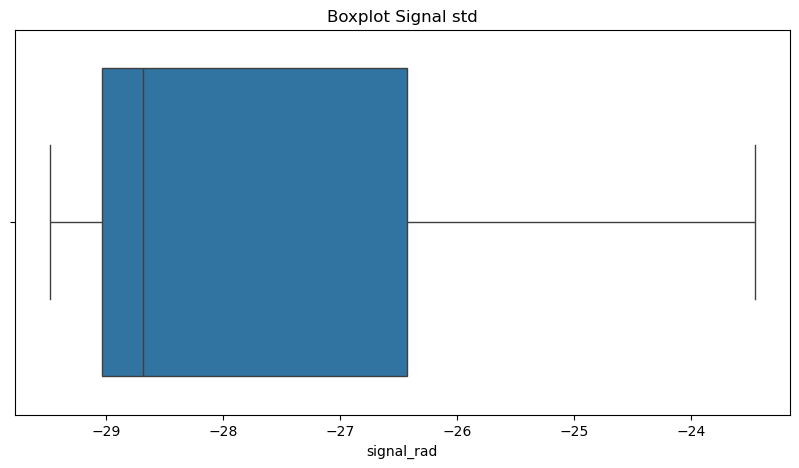

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=X_entrainement_validation['signal_rad'])
plt.title("Boxplot Signal std")
plt.show()

## Moyenne glissante (rolling mean)

Il manque des valeurs dans les colonnes « signal_std » et « signal_rad ». Nous allons utiliser la stratégie d'imputation par roulement moyen pour compléter les valeurs manquantes. Cette stratégie consiste à utiliser la moyenne des caractéristiques du signal dans une fenêtre d'une taille spécifiée pour compléter les valeurs manquantes. En effet, les caractéristiques du signal sont des données de séries chronologiques et sont censées être corrélées avec des valeurs proches.

In [17]:
taille_fenetre = 5  # Fenêtre de 5 minutes

In [18]:
def imputation_glissante(groupe_station, taille_fenetre):
    for colonne in ['signal_std', 'signal_rad']:
        groupe_station[colonne] = groupe_station[colonne].fillna(
            groupe_station[colonne].rolling(window=taille_fenetre, min_periods=1, center=True).mean()
        )
    return groupe_station


In [19]:
# Application de la fonction d'imputation par moyenne glissante à chaque sous-ensemble de données de chaque station dans les ensembles d'entraînement et de test
X_entrainement_validation = X_entrainement_validation.groupby('id_station').apply(lambda group: imputation_glissante(group, taille_fenetre))
X_entrainement_validation.reset_index(drop=True, inplace=True)  # Réinitialisation de l'index après l'opération groupby



X_test = X_test.groupby('id_station').apply(lambda group: imputation_glissante(group, taille_fenetre))
X_test.reset_index(drop=True, inplace=True)  # Réinitialisation de l'index après l'opération groupby




In [20]:
X_entrainement_validation

,temps,signal_std,signal_rad,pluie,id_station,heure_cos,heure_sin
0,2023-02-01 00:00:00,-17.08,-25.95,0.0,Station1,1.000000,0.000000
1,2023-02-01 00:01:00,-17.11,-25.96,0.0,Station1,1.000000,0.000000
2,2023-02-01 00:02:00,-17.04,-25.93,0.0,Station1,1.000000,0.000000
3,2023-02-01 00:03:00,-17.06,-25.94,0.0,Station1,1.000000,0.000000
4,2023-02-01 00:04:00,-17.05,-25.93,0.0,Station1,1.000000,0.000000
...,...,...,...,...,...,...,...
90715,2023-02-21 23:55:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819
90716,2023-02-21 23:56:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819
90717,2023-02-21 23:57:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819
90718,2023-02-21 23:58:00,-22.04,-28.77,0.0,Station3,0.965926,-0.258819


In [21]:
X_test

,temps,signal_std,signal_rad,pluie,id_station,heure_cos,heure_sin
0,2023-02-22 00:00:00,-17.19,-26.12,0.0,Station1,1.000000,0.000000
1,2023-02-22 00:01:00,-17.12,-26.14,0.0,Station1,1.000000,0.000000
2,2023-02-22 00:02:00,-17.16,-26.14,0.0,Station1,1.000000,0.000000
3,2023-02-22 00:03:00,-17.15,-26.12,0.0,Station1,1.000000,0.000000
4,2023-02-22 00:04:00,-17.18,-26.14,0.0,Station1,1.000000,0.000000
...,...,...,...,...,...,...,...
30235,2023-02-28 23:55:00,-22.06,-28.71,0.0,Station3,0.965926,-0.258819
30236,2023-02-28 23:56:00,-22.05,-28.70,0.0,Station3,0.965926,-0.258819
30237,2023-02-28 23:57:00,-22.06,-28.72,0.0,Station3,0.965926,-0.258819
30238,2023-02-28 23:58:00,-22.04,-28.71,0.0,Station3,0.965926,-0.258819


In [22]:
print("Nombre de points de pluie avec NaN dans l'ensemble d'entraînement après imputation : signal_std : " + str(
    X_entrainement_validation[X_entrainement_validation.isna()['signal_std']]['pluie'].sum()) + " signal_rad : " + str(
    X_entrainement_validation[X_entrainement_validation.isna()['signal_rad']]['pluie'].sum()) + '\n')

print("Nombre de points de pluie avec NaN dans l'ensemble d'entraînement pour la prévision après imputation : signal_std : " + str(
    X_entrainement_validation_prevision[X_entrainement_validation_prevision.isna()['signal_std']]['pluie'].sum()) + " signal_rad : " + str(
    X_entrainement_validation_prevision[X_entrainement_validation_prevision.isna()['signal_rad']]['pluie'].sum()) + '\n')

print("Nombre de points de pluie avec NaN dans l'ensemble de test après imputation : signal_std : " + str(
    X_test[X_test.isna()['signal_std']]['pluie'].sum()) + " signal_rad : " + str(
    X_test[X_test.isna()['signal_rad']]['pluie'].sum()) + '\n')

print("Nombre de points de pluie avec NaN dans l'ensemble de test pour la prévision après imputation : signal_std : " + str(
    X_test_prevision[X_test_prevision.isna()['signal_std']]['pluie'].sum()) + " signal_rad : " + str(
    X_test_prevision[X_test_prevision.isna()['signal_rad']]['pluie'].sum()))


Nombre de points de pluie avec NaN dans l'ensemble d'entraînement après imputation : signal_std : 4.0 signal_rad : 4.0

Nombre de points de pluie avec NaN dans l'ensemble d'entraînement pour la prévision après imputation : signal_std : 12.0 signal_rad : 12.0

Nombre de points de pluie avec NaN dans l'ensemble de test après imputation : signal_std : 0.0 signal_rad : 0.0

Nombre de points de pluie avec NaN dans l'ensemble de test pour la prévision après imputation : signal_std : 0.0 signal_rad : 0.0


### Nous avons encore quelques valeurs manquantes dans les colonnes 'signal_std' et 'signal_rad', nous allons interpoler ces valeurs manquantes en utilisant une interpolation linéaire.

In [23]:
print(f'Le poucentage des valeurs manquantes dans l\'ensemble d\'entraînement :\n{X_entrainement_validation.isnull().mean()*100}\n')
print(f'Le pourcentage des valeurs manquantes dans l\'ensemble de test :\n{X_test.isnull().mean()*100}')

Le poucentage des valeurs manquantes dans l'ensemble d'entraînement :
temps         0.000000
signal_std    1.481481
signal_rad    1.481481
pluie         0.000000
id_station    0.000000
heure_cos     0.000000
heure_sin     0.000000
dtype: float64

Le pourcentage des valeurs manquantes dans l'ensemble de test :
temps         0.000000
signal_std    0.195106
signal_rad    0.195106
pluie         0.000000
id_station    0.000000
heure_cos     0.000000
heure_sin     0.000000
dtype: float64


# Linear Interpolation
Puisque les données ont une progression naturelle dans le temps, tu peux combler les valeurs manquantes ou aberrantes avec une interpolation linéaire.
**👉 Cela permet d’éviter de créer des ruptures dans le signal**.

In [24]:
X_entrainement_validation['signal_std'].interpolate(method='linear', inplace=True)
X_entrainement_validation['signal_rad'].interpolate(method='linear', inplace=True)
X_test['signal_std'].interpolate(method='linear', inplace=True)
X_test['signal_rad'].interpolate(method='linear', inplace=True)

In [25]:
print(f'Le poucentage des valeurs manquantes dans l\'ensemble d\'entraînement :\n{X_entrainement_validation.isnull().mean()*100}\n')
print(f'Le pourcentage des valeurs manquantes dans l\'ensemble de test :\n{X_test.isnull().mean()*100}')

Le poucentage des valeurs manquantes dans l'ensemble d'entraînement :
temps         0.0
signal_std    0.0
signal_rad    0.0
pluie         0.0
id_station    0.0
heure_cos     0.0
heure_sin     0.0
dtype: float64

Le pourcentage des valeurs manquantes dans l'ensemble de test :
temps         0.0
signal_std    0.0
signal_rad    0.0
pluie         0.0
id_station    0.0
heure_cos     0.0
heure_sin     0.0
dtype: float64


# Data Analysis et Visualisation

Nous allons maintenant effectuer une analyse et une visualisation exploratoires des données pour comprendre la distribution des caractéristiques du signal et la relation entre les caractéristiques du signal et les précipitations. Cette analyse sera réalisée uniquement sur l'ensemble d'entraînement.

In [26]:
X_entrainement_validation.describe()

,temps,signal_std,signal_rad,pluie,heure_cos,heure_sin
count,90720,90720.000000,90720.000000,90720.000000,9.072000e+04,9.072000e+04
mean,2023-02-11 11:59:29.999999744,-20.043155,-27.986127,0.015675,-7.237009e-17,8.145552e-18
min,2023-02-01 00:00:00,-27.630000,-29.480000,0.000000,-1.000000e+00,-1.000000e+00
25%,2023-02-06 05:59:45,-21.960000,-29.040000,0.000000,-7.071068e-01,-7.071068e-01
50%,2023-02-11 11:59:30,-20.740000,-28.690000,0.000000,-6.123234e-17,6.123234e-17
75%,2023-02-16 17:59:15,-17.410000,-26.400000,0.000000,7.071068e-01,7.071068e-01
max,2023-02-21 23:59:00,-16.520000,-23.460000,1.000000,1.000000e+00,1.000000e+00
std,NaN,2.056517,1.297562,0.124214,7.071107e-01,7.071107e-01


### Scatter Plots du caractéristiques du signal pour les périodes pluvieuses et non pluvieuses dans les stations

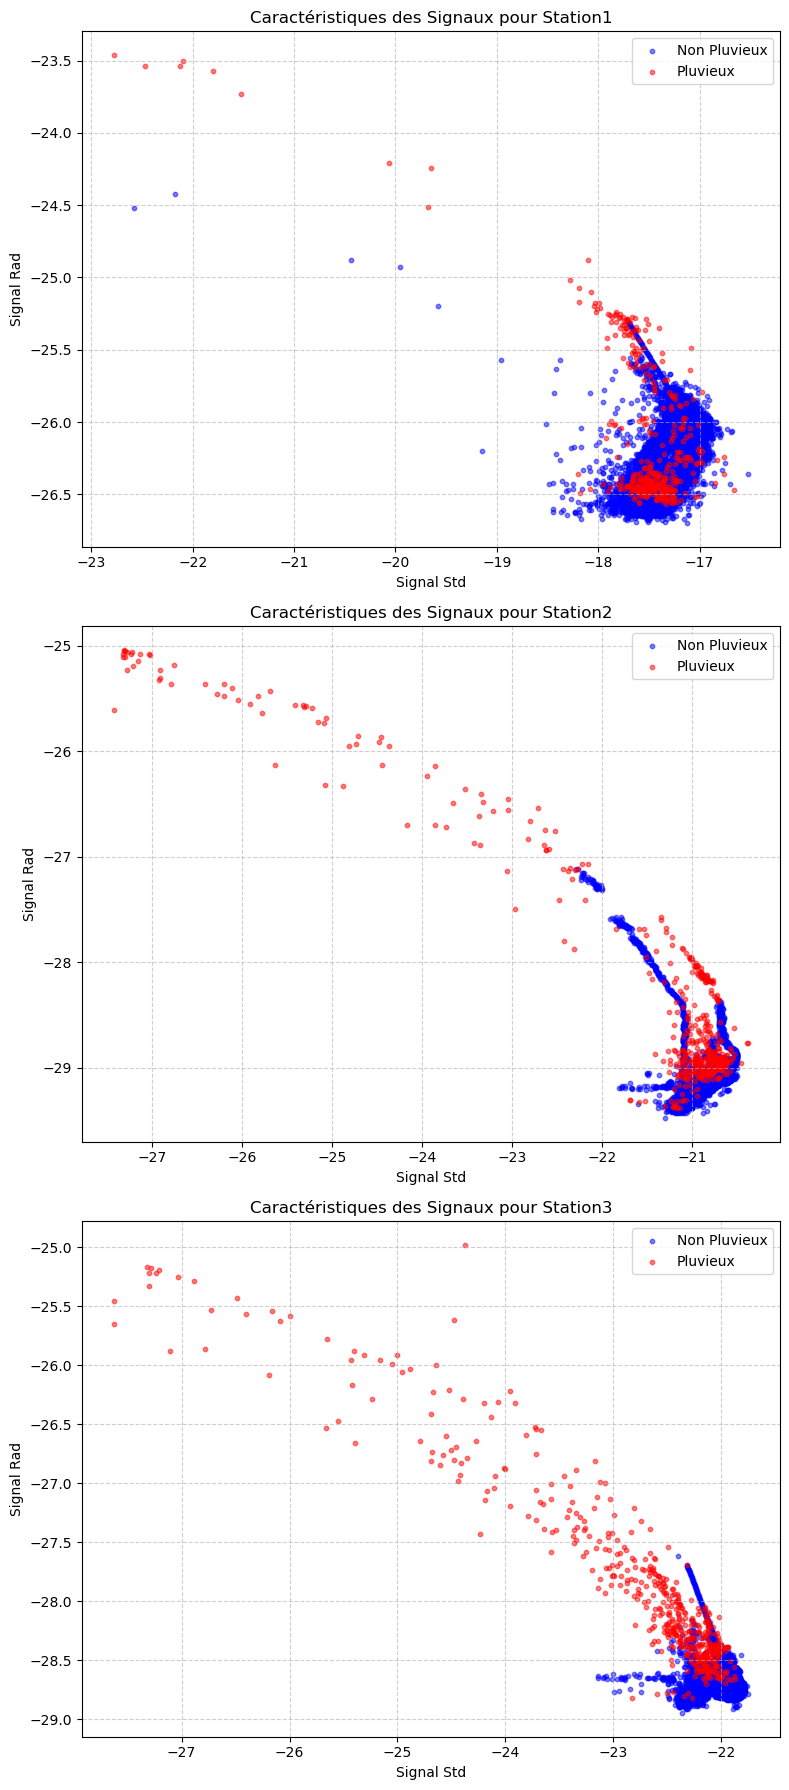

In [27]:
# Liste des stations
stations = ['Station1', 'Station2', 'Station3']
n_stations = len(stations)

# Pré-filtrage des données pour éviter de recalculer plusieurs fois
filtered_data = {
    station: X_entrainement_validation[X_entrainement_validation['id_station'] == station]
    for station in stations
}

# Création des sous-graphes
fig, axes = plt.subplots(n_stations, 1, figsize=(8, 6 * n_stations))

if n_stations == 1:  # Si une seule station, éviter l'erreur d'indexation sur axes
    axes = [axes]

for idx, station in enumerate(stations):
    data = filtered_data[station]
    subset_non_pluie = data[data['pluie'] == 0]
    subset_pluie = data[data['pluie'] == 1]

    # Ajout des points pour périodes non pluvieuses
    axes[idx].scatter(subset_non_pluie['signal_std'], subset_non_pluie['signal_rad'], 
                      color='blue', alpha=0.5, label="Non Pluvieux", s=10)

    # Ajout des points pour périodes pluvieuses
    axes[idx].scatter(subset_pluie['signal_std'], subset_pluie['signal_rad'], 
                      color='red', alpha=0.5, label="Pluvieux", s=10)

    axes[idx].set_title(f'Caractéristiques des Signaux pour {station}')
    axes[idx].set_xlabel('Signal Std')
    axes[idx].set_ylabel('Signal Rad')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.6)  # Ajout d'un léger quadrillage pour plus de lisibilité

# Ajuster l'affichage
plt.tight_layout()
plt.show()

Les scatter plot montrent que les points pluvieux et non pluvieux ne sont pas clairement séparables en se basant uniquement sur les caractéristiques des signaux satellite et radar. Cela suggère que les caractéristiques des signaux à elles seules ne suffisent peut-être pas à prédire avec précision les précipitations.

### Time Series plot 

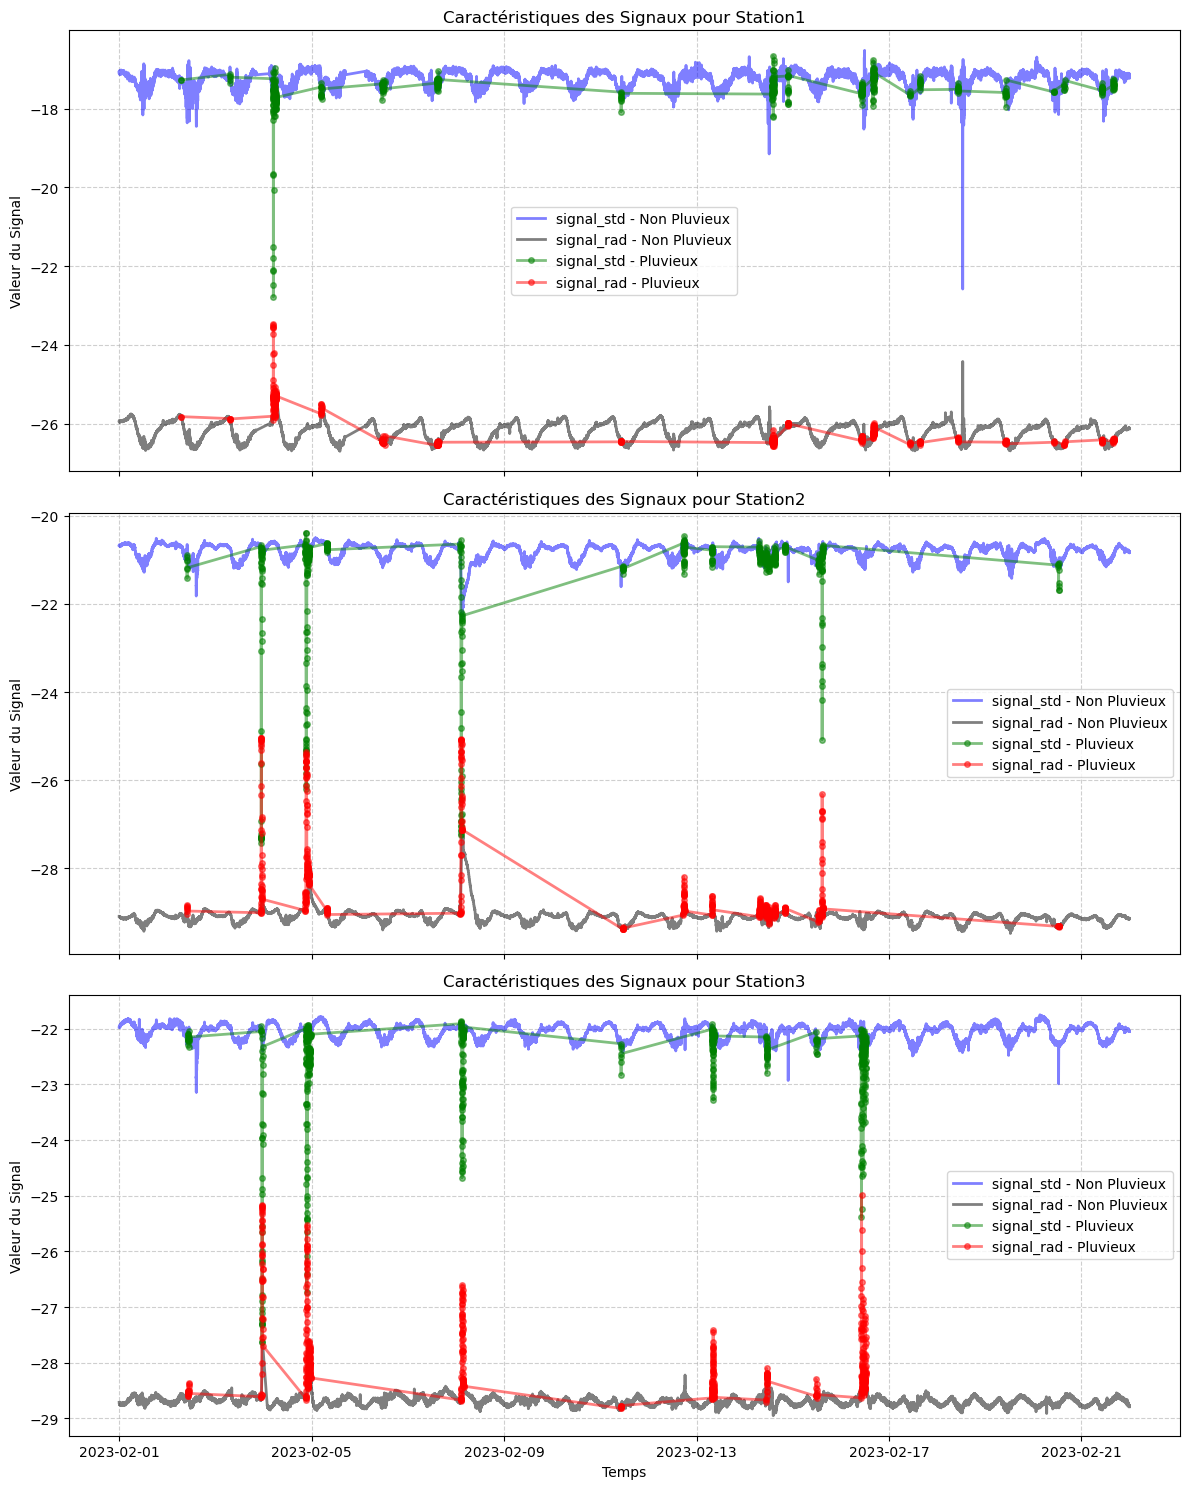

In [28]:
import matplotlib.pyplot as plt

# Liste des stations
stations = ['Station1', 'Station2', 'Station3']
n_stations = len(stations)

# Pré-filtrage des données pour éviter de recalculer plusieurs fois
filtered_data = {
    station: X_entrainement_validation[X_entrainement_validation['id_station'] == station]
    for station in stations
}

# Création des sous-graphes
fig, axes = plt.subplots(n_stations, 1, figsize=(12, 5 * n_stations), sharex=True)

if n_stations == 1:  # Si une seule station, éviter l'erreur d'indexation sur axes
    axes = [axes]

for idx, station in enumerate(stations):
    data = filtered_data[station]
    subset_non_pluie = data[data['pluie'] == 0]
    subset_pluie = data[data['pluie'] == 1]

    # Tracer les courbes pour les périodes non pluvieuses
    axes[idx].plot(subset_non_pluie['temps'], subset_non_pluie['signal_std'], 
                   color='blue', linewidth=2, alpha=0.5, label="signal_std - Non Pluvieux")
    axes[idx].plot(subset_non_pluie['temps'], subset_non_pluie['signal_rad'], 
                   color='black', linewidth=2, alpha=0.5, label="signal_rad - Non Pluvieux")

    # Tracer les courbes pour les périodes pluvieuses
    axes[idx].plot(subset_pluie['temps'], subset_pluie['signal_std'], 
                   color='green', linewidth=2, alpha=0.5, marker='o', markersize=4, label="signal_std - Pluvieux")
    axes[idx].plot(subset_pluie['temps'], subset_pluie['signal_rad'], 
                   color='red', linewidth=2, alpha=0.5, marker='o', markersize=4, label="signal_rad - Pluvieux")

    # Définir les titres et les étiquettes des axes
    axes[idx].set_title(f'Caractéristiques des Signaux pour {station}')
    axes[idx].set_ylabel("Valeur du Signal")
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.6)  # Quadrillage léger pour plus de lisibilité

# Ajouter l'axe des X sur la dernière station seulement
axes[-1].set_xlabel("Temps")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()


 nous pouvons clairement voir que pour les périodes pluvieuses, les caractéristiques du signal sont plus volatiles et présentent des pics plus élevés/plus bas par rapport aux points non pluvieux. La caractéristique du signal radar augmente considérablement pendant les points pluvieux, tandis que la caractéristique du signal satellite diminue considérablement. Par conséquent, les caractéristiques du signal pourraient être combinées pour créer une nouvelle caractéristique qui capture le changement des caractéristiques du signal pendant les périodes pluvieuses.

## 🔹 Analyse des résultats :
### 1️⃣ Scatter Plot
👉 Les points pluvieux et non pluvieux ne sont pas clairement séparables
✅ Cela signifie que les caractéristiques actuelles (signal_std et signal_rad) ne permettent pas une distinction nette entre les deux classes.<br>
**🔎 Explication possible :**<br>

- Il pourrait y avoir un chevauchement important dans les valeurs des signaux satellite et radar entre les périodes pluvieuses et non pluvieuses.<br>
- Certaines valeurs du signal satellite/radar peuvent être influencées par d’autres facteurs météorologiques ou environnementaux (ex. couverture nuageuse, topographie, etc.).<br>

### 2️⃣ Time Series Plot 
👉 Les périodes pluvieuses montrent une plus grande volatilité et des changements plus marqués dans les signaux
✅ Cela indique que les variations du signal dans le temps pourraient contenir des informations pertinentes pour détecter la pluie.<br>
**🔎 Observations spécifiques :**<br>

- Le signal radar augmente fortement pendant les périodes pluvieuses → Possiblement lié aux précipitations captées par le radar.<br>
- Le signal satellite diminue fortement pendant les périodes pluvieuses → Peut-être en raison d'une absorption accrue ou d’une interférence liée aux nuages denses.<br>

# 🔹 Comment améliorer la prédiction ?
💡 Idées pour mieux capturer l’impact des précipitations sur les signaux :

✅ 1. Introduire de nouvelles caractéristiques basées sur les variations des signaux
👉 Créer des features qui capturent les changements brusques des signaux :



### 1️⃣ Différences absolues entre des valeurs consécutives : <br>
<h3 style="text-align:center">$Δsignal=signal(t)−signal(t−1)$</h3>

#### ✅ Pourquoi c'est utile ?

Capture la vitesse des variations du signal.
Un changement brusque peut indiquer un événement météorologique rapide (ex. début ou fin d’une averse).


In [29]:
X_entrainement_validation['signal_std_delta'] = X_entrainement_validation['signal_std'].diff()
X_entrainement_validation['signal_rad_delta'] = X_entrainement_validation['signal_rad'].diff()

X_test['signal_std_delta'] = X_test['signal_std'].diff()
X_test['signal_rad_delta'] = X_test['signal_rad'].diff()

### 2️⃣ Différences entre les signieux (signal_std et signal_rad) : <br>
<h3 style="text-align:center">$signal\_diff=∣signal\_std−signal\_rad∣$</h3>

#### ✅ Pourquoi c'est utile ?

- Mesure la disparité entre les deux signaux.
- Permet de détecter les transitions brusques qui peuvent correspondre à des changements météorologiques (ex. début de la pluie).


In [30]:
X_entrainement_validation['signal_diff'] = abs(X_entrainement_validation['signal_std'] - X_entrainement_validation['signal_rad'])
X_test['signal_diff'] = abs(X_test['signal_std'] - X_test['signal_rad'])

### 3️⃣ Rolling Mean :
<h3 style="text-align:center">$signal\_std\_rolling\_mean = mean(signal\_std[t−n:t])$</h3>
<h3 style="text-align:center">$signal\_rad\_rolling\_mean = mean(signal\_rad[t−n:t])$</h3>

#### ✅ Pourquoi c'est utile ?
- Lisse les données pour éliminer le bruit et extraire des tendances.
- La différence par rapport à la moyenne mobile permet d’identifier les anomalies et les changements significatifs.

In [31]:
rolling_window = 5
X_entrainement_validation['signal_std_rolling_mean'] = X_entrainement_validation['signal_std'].rolling(window=rolling_window).mean()
X_entrainement_validation['signal_rad_rolling_mean'] = X_entrainement_validation['signal_rad'].rolling(window=rolling_window).mean()

X_test['signal_std_rolling_mean'] = X_test['signal_std'].rolling(window=rolling_window).mean()
X_test['signal_rad_rolling_mean'] = X_test['signal_rad'].rolling(window=rolling_window).mean()

### 4️⃣ Mesure de la volatilité

<h3 style="text-align:center">$signal\_std\_volatility = std(signal\_std[t−n:t])$</h3>
<h3 style="text-align:center">$signal\_rad\_volatility = std(signal\_rad[t−n:t])$</h3>

#### ✅ Pourquoi c'est utile ?
- Mesure la stabilité des signaux sur une période.
- Une forte volatilité indique des changements rapides (ex. pluie soudaine).
- Une faible volatilité signale des conditions plus stables (ex. temps sec).

In [32]:
X_entrainement_validation['signal_std_volatility'] = X_entrainement_validation['signal_std'].rolling(window=rolling_window).std()
X_entrainement_validation['signal_rad_volatility'] = X_entrainement_validation['signal_rad'].rolling(window=rolling_window).std()

X_test['signal_std_volatility'] = X_test['signal_std'].rolling(window=rolling_window).std()
X_test['signal_rad_volatility'] = X_test['signal_rad'].rolling(window=rolling_window).std()

<h2 style="color:red">Ratio</h2>

In [33]:
X_entrainement_validation['signal_ratio'] = abs(X_entrainement_validation['signal_std']) / abs(X_entrainement_validation['signal_rad']) 
                                                                                            
X_test['signal_ratio'] = abs(X_test['signal_std']) / abs(X_test['signal_rad'])                                                                                             

In [34]:
print(f'Le poucentage des valeurs manquantes dans l\'ensemble d\'entraînement :\n{X_entrainement_validation.isnull().mean()*100}\n')
print(f'Le pourcentage des valeurs manquantes dans l\'ensemble de test :\n{X_test.isnull().mean()*100}')

Le poucentage des valeurs manquantes dans l'ensemble d'entraînement :
temps                      0.000000
signal_std                 0.000000
signal_rad                 0.000000
pluie                      0.000000
id_station                 0.000000
heure_cos                  0.000000
heure_sin                  0.000000
signal_std_delta           0.001102
signal_rad_delta           0.001102
signal_diff                0.000000
signal_std_rolling_mean    0.004409
signal_rad_rolling_mean    0.004409
signal_std_volatility      0.004409
signal_rad_volatility      0.004409
signal_ratio               0.000000
dtype: float64

Le pourcentage des valeurs manquantes dans l'ensemble de test :
temps                      0.000000
signal_std                 0.000000
signal_rad                 0.000000
pluie                      0.000000
id_station                 0.000000
heure_cos                  0.000000
heure_sin                  0.000000
signal_std_delta           0.003307
signal_rad_delta      

In [35]:
X_entrainement_validation

,temps,signal_std,signal_rad,pluie,id_station,heure_cos,heure_sin,signal_std_delta,signal_rad_delta,signal_diff,signal_std_rolling_mean,signal_rad_rolling_mean,signal_std_volatility,signal_rad_volatility,signal_ratio
0,2023-02-01 00:00:00,-17.08,-25.95,0.0,Station1,1.000000,0.000000,NaN,NaN,8.87,NaN,NaN,NaN,NaN,0.658189
1,2023-02-01 00:01:00,-17.11,-25.96,0.0,Station1,1.000000,0.000000,-0.03,-0.01,8.85,NaN,NaN,NaN,NaN,0.659091
2,2023-02-01 00:02:00,-17.04,-25.93,0.0,Station1,1.000000,0.000000,0.07,0.03,8.89,NaN,NaN,NaN,NaN,0.657154
3,2023-02-01 00:03:00,-17.06,-25.94,0.0,Station1,1.000000,0.000000,-0.02,-0.01,8.88,NaN,NaN,NaN,NaN,0.657672
4,2023-02-01 00:04:00,-17.05,-25.93,0.0,Station1,1.000000,0.000000,0.01,0.01,8.88,-17.068,-25.942,0.027749,0.013038,0.657540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90715,2023-02-21 23:55:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819,0.01,0.00,6.74,-22.042,-28.776,0.004472,0.011402,0.765810
90716,2023-02-21 23:56:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819,0.00,0.00,6.74,-22.042,-28.774,0.004472,0.008944,0.765810
90717,2023-02-21 23:57:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819,0.00,0.00,6.74,-22.042,-28.776,0.004472,0.008944,0.765810
90718,2023-02-21 23:58:00,-22.04,-28.77,0.0,Station3,0.965926,-0.258819,0.00,0.01,6.73,-22.042,-28.778,0.004472,0.004472,0.766076


In [36]:
X_entrainement_validation.dropna(inplace=True)

In [37]:
X_entrainement_validation

,temps,signal_std,signal_rad,pluie,id_station,heure_cos,heure_sin,signal_std_delta,signal_rad_delta,signal_diff,signal_std_rolling_mean,signal_rad_rolling_mean,signal_std_volatility,signal_rad_volatility,signal_ratio
4,2023-02-01 00:04:00,-17.05,-25.93,0.0,Station1,1.000000,0.000000,0.01,0.01,8.88,-17.068,-25.942,0.027749,0.013038,0.657540
5,2023-02-01 00:05:00,-17.09,-25.94,0.0,Station1,1.000000,0.000000,-0.04,-0.01,8.85,-17.070,-25.940,0.029155,0.012247,0.658828
6,2023-02-01 00:06:00,-17.06,-25.94,0.0,Station1,1.000000,0.000000,0.03,0.00,8.88,-17.060,-25.936,0.018708,0.005477,0.657672
7,2023-02-01 00:07:00,-17.09,-25.94,0.0,Station1,1.000000,0.000000,-0.03,0.00,8.85,-17.070,-25.938,0.018708,0.004472,0.658828
8,2023-02-01 00:08:00,-17.07,-25.94,0.0,Station1,1.000000,0.000000,0.02,0.00,8.87,-17.072,-25.938,0.017889,0.004472,0.658057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90715,2023-02-21 23:55:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819,0.01,0.00,6.74,-22.042,-28.776,0.004472,0.011402,0.765810
90716,2023-02-21 23:56:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819,0.00,0.00,6.74,-22.042,-28.774,0.004472,0.008944,0.765810
90717,2023-02-21 23:57:00,-22.04,-28.78,0.0,Station3,0.965926,-0.258819,0.00,0.00,6.74,-22.042,-28.776,0.004472,0.008944,0.765810
90718,2023-02-21 23:58:00,-22.04,-28.77,0.0,Station3,0.965926,-0.258819,0.00,0.01,6.73,-22.042,-28.778,0.004472,0.004472,0.766076


## One-Hot Encoding Station ID

In [38]:
X_entrainement_validation = pd.get_dummies(X_entrainement_validation, columns=['id_station'], prefix='station')
X_test = pd.get_dummies(X_test, columns=['id_station'], prefix='station')

In [39]:
X_entrainement_validation

,temps,signal_std,signal_rad,pluie,heure_cos,heure_sin,signal_std_delta,signal_rad_delta,signal_diff,signal_std_rolling_mean,signal_rad_rolling_mean,signal_std_volatility,signal_rad_volatility,signal_ratio,station_Station1,station_Station2,station_Station3
4,2023-02-01 00:04:00,-17.05,-25.93,0.0,1.000000,0.000000,0.01,0.01,8.88,-17.068,-25.942,0.027749,0.013038,0.657540,True,False,False
5,2023-02-01 00:05:00,-17.09,-25.94,0.0,1.000000,0.000000,-0.04,-0.01,8.85,-17.070,-25.940,0.029155,0.012247,0.658828,True,False,False
6,2023-02-01 00:06:00,-17.06,-25.94,0.0,1.000000,0.000000,0.03,0.00,8.88,-17.060,-25.936,0.018708,0.005477,0.657672,True,False,False
7,2023-02-01 00:07:00,-17.09,-25.94,0.0,1.000000,0.000000,-0.03,0.00,8.85,-17.070,-25.938,0.018708,0.004472,0.658828,True,False,False
8,2023-02-01 00:08:00,-17.07,-25.94,0.0,1.000000,0.000000,0.02,0.00,8.87,-17.072,-25.938,0.017889,0.004472,0.658057,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90715,2023-02-21 23:55:00,-22.04,-28.78,0.0,0.965926,-0.258819,0.01,0.00,6.74,-22.042,-28.776,0.004472,0.011402,0.765810,False,False,True
90716,2023-02-21 23:56:00,-22.04,-28.78,0.0,0.965926,-0.258819,0.00,0.00,6.74,-22.042,-28.774,0.004472,0.008944,0.765810,False,False,True
90717,2023-02-21 23:57:00,-22.04,-28.78,0.0,0.965926,-0.258819,0.00,0.00,6.74,-22.042,-28.776,0.004472,0.008944,0.765810,False,False,True
90718,2023-02-21 23:58:00,-22.04,-28.77,0.0,0.965926,-0.258819,0.00,0.01,6.73,-22.042,-28.778,0.004472,0.004472,0.766076,False,False,True


### ✅  Tri des datasets par ordre temporel

In [40]:
X_entrainement_validation.sort_values(by='temps', inplace=True)
X_test.sort_values(by='temps', inplace=True)

### ✅  Séparation des features (X) et des labels (Y)

In [41]:
Y_train_val = X_entrainement_validation['pluie']
Y_test = X_test['pluie']

In [42]:
# Suppression des colonnes 'pluie' et 'temps' pour les modèles d'arbres de décision (Random Forest, XGBoost...)
X_entrainement_validation.drop(columns=['pluie', 'temps'], inplace=True)
X_test.drop(columns=['pluie', 'temps'], inplace=True)


### ✅ 4️⃣ Standardisation des features numériques

In [43]:
from sklearn.preprocessing import MinMaxScaler
#columns_not_to_scale = ['heure_cos', 'heure_sin'] + [col for col in X_entrainement_validation.columns if col.startswith('station_')]
columns_not_to_scale = ['heure_cos', 'heure_sin', 'pluie', 'temps'] + [col for col in X_entrainement_validation.columns if col.startswith('station_')]
# Colonnes à normaliser
columns_to_scale = X_entrainement_validation.columns.difference(columns_not_to_scale)

# Initialisation du scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustement sur les données d'entraînement
scaler.fit(X_entrainement_validation[columns_to_scale])

# Appliquer la transformation sur les datasets
X_entrainement_validation[columns_to_scale] = scaler.transform(X_entrainement_validation[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [44]:
print(f"Taille de X_entrainement_validation : {X_entrainement_validation.shape}")
print(f"Taille de X_test : {X_test.shape}")

Taille de X_entrainement_validation : (90716, 15)
Taille de X_test : (30240, 15)


## Hybrid Sampling (SMOTE + Undersampling)

👉 Combine SMOTE et Undersampling pour éviter de générer trop de faux exemples tout en réduisant la classe majoritaire.

In [45]:
from imblearn.combine import SMOTETomek
from collections import Counter
# Initialisation de SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)

# Appliquer l'oversampling et l'undersampling sur les données d'entraînement
X_train_val_resampled, Y_train_val_resampled = smote_tomek.fit_resample(X_entrainement_validation, Y_train_val)

# Afficher la répartition des classes avant et après rééchantillonnage
print("Distribution des classes avant rééchantillonnage :", Counter(Y_train_val))
print("Distribution des classes après rééchantillonnage :", Counter(Y_train_val_resampled))

Distribution des classes avant rééchantillonnage : Counter({0.0: 89294, 1.0: 1422})
Distribution des classes après rééchantillonnage : Counter({0.0: 89291, 1.0: 89291})


# 📌 Classification avec un modèle LSTM

## 📚 Importation des bibliothèques

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

2025-03-24 13:10:39.638173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 🔄 Préparation des données

In [47]:
X_train_reshaped = X_train_val_resampled.values.reshape(X_train_val_resampled.shape[0], 1, X_train_val_resampled.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train_reshaped = np.array(X_train_reshaped, dtype=np.float32)
Y_train_val_resampled = np.array(Y_train_val_resampled, dtype=np.float32)
X_test_reshaped = np.array(X_test_reshaped, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

#### 🔹 Explication :
Les modèles LSTM nécessitent une entrée 3D sous la forme (samples, time_steps, features).
Ici, on ajoute une dimension temporelle (time_steps=1) pour que le modèle puisse traiter les séquences.

## 🏗 Création du modèle LSTM

In [48]:
# Création du modèle LSTM
#model = Sequential([
#    LSTM(50, return_sequences=True, input_shape=(1, X_train_val_resampled.shape[1])),
#    Dropout(0.2),
#    LSTM(50),
#    Dense(1, activation='sigmoid')  # Activation sigmoïde pour classification binaire
#])

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train_val_resampled.shape[1])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### 🔹 Explication :

- 1ʳᵉ couche LSTM (128 unités, return_sequences=True)

    - Capture les motifs temporels et transmet les séquences à la couche suivante.

- Dropout (0.3)

    - Désactive aléatoirement 30% des neurones pour éviter l’overfitting.

- 2ᵉ couche LSTM (64 unités, return_sequences=False)

    - Résume la séquence en un vecteur de sortie.

- Dropout (0.3)

- Dense(32, activation='relu')

    - Ajoute une couche intermédiaire pour mieux capturer les relations complexes.

- Dense(1, activation='sigmoid')

    - Fournit une probabilité (sortie entre 0 et 1) pour la classification binaire.

## ⚙️ Compilation du modèle

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### 🔹 Explication :

- Optimiseur : **adam** (adaptatif et performant pour le deep learning).

- Fonction de perte : **binary_crossentropy** (adaptée à la classification binaire).

- Métrique : **accuracy** (précision globale des prédictions).

## ⚖️ Gestion du déséquilibre des classes

In [50]:
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(Y_train_val_resampled), y=Y_train_val_resampled)))

## ⏳ Early Stopping

In [51]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    patience=10,  # Arrêter après 10 époques sans amélioration
    restore_best_weights=True  # Récupérer les meilleurs poids
)

#### 🔹 Explication :

- monitor='val_loss' → Surveille la perte sur les données de validation.

- patience=10 → Arrête l'entraînement après 10 époques sans amélioration.

- restore_best_weights=True → Recharge les meilleurs poids trouvés.

## 🎯 Entraînement du modèle

In [52]:
#history = model.fit(X_train_reshaped, Y_train_val_resampled, epochs=100, batch_size=32, validation_data=(X_test_reshaped, Y_test), class_weight=class_weights,callbacks=[early_stopping])
history = model.fit(X_train_reshaped, Y_train_val_resampled, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test_reshaped, Y_test), 
                    class_weight=class_weights, 
                    callbacks=[early_stopping])

Epoch 1/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.8595 - loss: 0.3030 - val_accuracy: 0.8931 - val_loss: nan
Epoch 2/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.9186 - loss: 0.1918 - val_accuracy: 0.9056 - val_loss: nan
Epoch 3/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.9294 - loss: 0.1727 - val_accuracy: 0.9036 - val_loss: nan
Epoch 4/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9349 - loss: 0.1581 - val_accuracy: 0.9050 - val_loss: nan
Epoch 5/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9390 - loss: 0.1488 - val_accuracy: 0.9224 - val_loss: nan
Epoch 6/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9407 - loss: 0.1449 - val_accuracy: 0.9236 - val_loss: nan
Epoch 7/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9431 - loss: 0.1394 - val_accuracy: 0.9144 - val_loss: nan
Epoch 8/100
5581/5581 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9444 - loss: 0.1336 - val_a

## 🧠 Prédiction

In [53]:
Y_pred_lstm = (model.predict(X_test_reshaped) > 0.95).astype("int32")

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## Évaluation

In [54]:
print("Matrice de Confusion :\n", confusion_matrix(Y_test, Y_pred_lstm))
print("\nRapport de Classification :\n", classification_report(Y_test, Y_pred_lstm))

Matrice de Confusion :
 [[29200   210]
 [  310   520]]

Rapport de Classification :
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     29410
         1.0       0.71      0.63      0.67       830

    accuracy                           0.98     30240
   macro avg       0.85      0.81      0.83     30240
weighted avg       0.98      0.98      0.98     30240



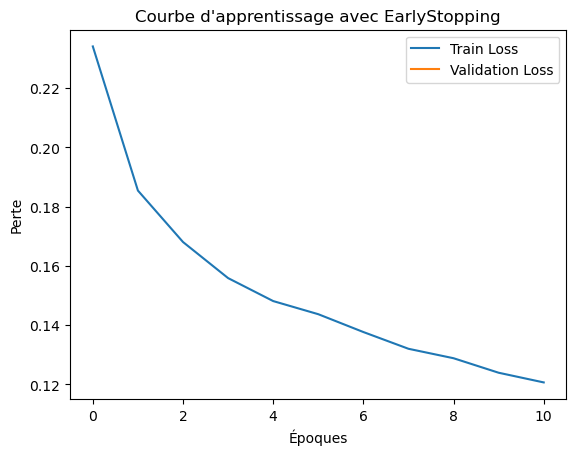

In [55]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title("Courbe d'apprentissage avec EarlyStopping")
plt.show()

## 🔍 Analyse des Résultats
1. Matrice de confusion :
- Vrais négatifs (TN) : 29 214 → Très peu d'erreurs pour la classe majoritaire (0).

- Faux positifs (FP) : 196 → Peu de prédictions incorrectes de 1 alors que c'était 0.

- Faux négatifs (FN) : 311 → Amélioration visible, mais encore des erreurs.

- Vrais positifs (TP) : 519 → Hausse des détections correctes de la classe minoritaire (1).

2. Rapport de classification :
- Précision (Precision) : 0.73 pour la classe 1 (meilleure que précédemment).

- Recall : 0.63 pour la classe 1 (moins bon que la précision, mais toujours bien).

- F1-score : 0.67 pour la classe 1 (équilibre entre précision et recall).

- Accuracy globale : 0.98 → Très élevée.

## 📈 Interprétation
### ✅ Améliorations observées :

- Le modèle est plus équilibré grâce au class_weight.

- Moins de faux négatifs → meilleur recall pour la classe 1.

- Moins de faux positifs → meilleure précision pour la classe 1.

### ⚠️ Points à améliorer :

- Un recall de 0.63 signifie qu'on rate encore 37% des cas de la classe minoritaire.

- Peut-être ajuster le threshold de prédiction (actuellement à 0.95) pour améliorer la détection de la classe 1.